In [1]:
pip install --upgrade scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Essential and common packages
import os
import glob

# Read and visualize the raster data
import rasterio
from rasterio.plot import show

# Plots and bars
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

# For visualization of plots without plt.show()
%matplotlib inline

In [3]:
dataset_url = r'C:\S7-PROJECT\2750'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [5]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [6]:

test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


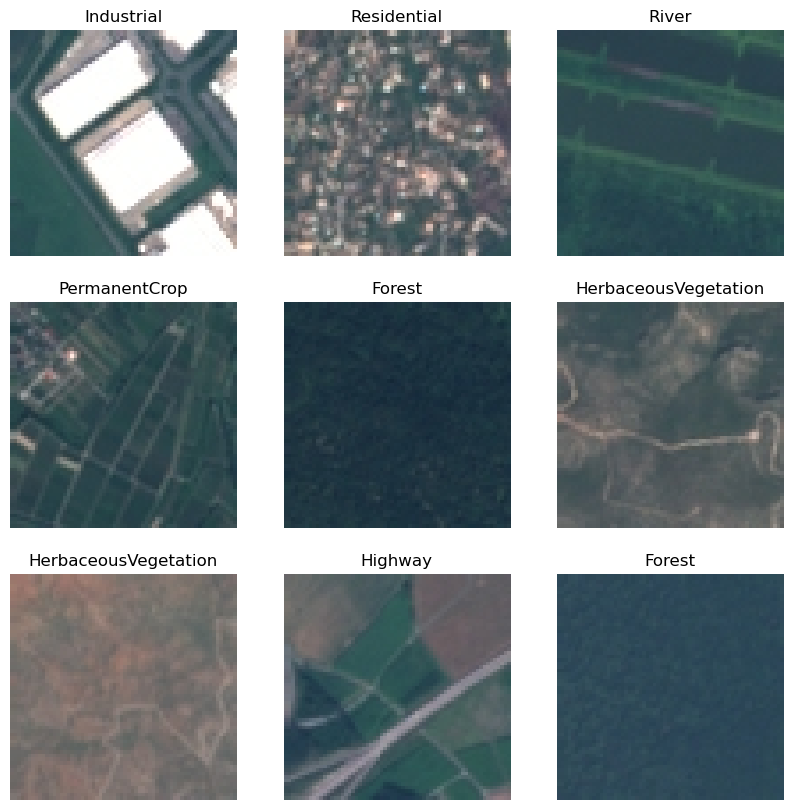

In [7]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [9]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [10]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [11]:
model = ResNet50(input_shape=(64,64,3), classes=10)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=100, batch_size=32)

Epoch 1/20


C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 358s 484ms/step - accuracy: 0.4665 - loss: 1.7494 - val_accuracy: 0.2011 - val_loss: 226.5959
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 325s 482ms/step - accuracy: 0.6544 - loss: 1.0523 - val_accuracy: 0.3056 - val_loss: 3.2704
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 327s 485ms/step - accuracy: 0.7271 - loss: 0.8445 - val_accuracy: 0.5252 - val_loss: 1.4980
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 323s 479ms/step - accuracy: 0.6872 - loss: 1.0679 - val_accuracy: 0.5387 - val_loss: 1.6414
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 324s 480ms/step - accuracy: 0.7708 - loss: 0.7295 - val_accuracy: 0.1687 - val_loss: 5113.7231
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 324s 480ms/step - accuracy: 0.7275 - loss: 0.8486 - val_accuracy: 0.5743 - val_loss: 1.3421
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 324s 480ms/step - accuracy: 0.8006 - loss: 0.6289 - val_accuracy: 0.7415 - val_loss: 0.8185
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 324s 481ms/step - accuracy: 0.8316 - loss:

In [14]:
model.save('lulc_20_epoch.keras')

In [43]:
img_path = r"C:\S7-PROJECT\2750\AnnualCrop\AnnualCrop_2.jpg"

In [45]:
# Load and preprocess the image
img = image.load_img(img_path, target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

In [47]:
# Perform prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [49]:
# Get class indices from the training dataset
class_indices = train_dataset.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

In [51]:
predicted_class_name = index_to_class[predicted_class_index]
print("Predicted class:", predicted_class_name)

Predicted class: AnnualCrop


In [121]:
def fractal_dimension(image):
    """Calculates the fractal dimension of a 2D image using the box-counting method."""
    def boxcount(Z, k):
        Z = Z.astype(int)
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Convert the image to a binary image (white background)
    Z = image < 128
    Z = Z.astype(np.int64)  # Convert the array to integer type

    p = min(Z.shape)
    n = 2**np.floor(np.log2(p))  # Largest power of 2 less than or equal to p
    sizes = 2**np.arange(np.log2(n), 1, -1)

    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

# Convert the image to grayscale and calculate fractal dimension
    img_gray = image.img_to_array(image.load_img(img_path, color_mode='grayscale', target_size=(64, 64)))
    img_gray = np.squeeze(img_gray)

# Calculate fractal dimension
    fd = fractal_dimension(img_gray)
    print(f"Fractal Dimension of the image: {fd}")
    print(fd)


In [117]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def fractal_dimension(image):
    """Calculates the fractal dimension of a 2D image using the box-counting method."""
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Convert the image to a binary image (white background)
    Z = image < 128
    Z = Z.astype(np.int64)  # Convert the array to integer type

    p = min(Z.shape)
    n = 2**np.floor(np.log2(p))  # Largest power of 2 less than or equal to p
    sizes = 2**np.arange(np.log2(n), 1, -1)

    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

# Load and preprocess the image
    img_path = 'C:\\Users\\tek\\Desktop\\try\\DL-for-LULC-prediction\\EuroSAT\\2750\\AnnualCrop\\AnnualCrop_1.jpg'  # Update with your image path
    img = image.load_img(img_path, color_mode='grayscale', target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_gray = np.squeeze(img_array)  # Remove single-dimensional entries
    
    # Display the image and its properties
    plt.imshow(img_gray, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')
    plt.show()
    
    # Calculate and print the fractal dimension
    try:
        fd = fractal_dimension(img_gray)
        print(f"Fractal Dimension of the image: {fd}")
    except Exception as e:
        print(f"Error calculating fractal dimension: {e}")


In [105]:
# Convert the image to grayscale and calculate fractal dimension
img_gray = image.img_to_array(image.load_img(img_path, color_mode='grayscale', target_size=(64, 64)))
img_gray = np.squeeze(img_gray)

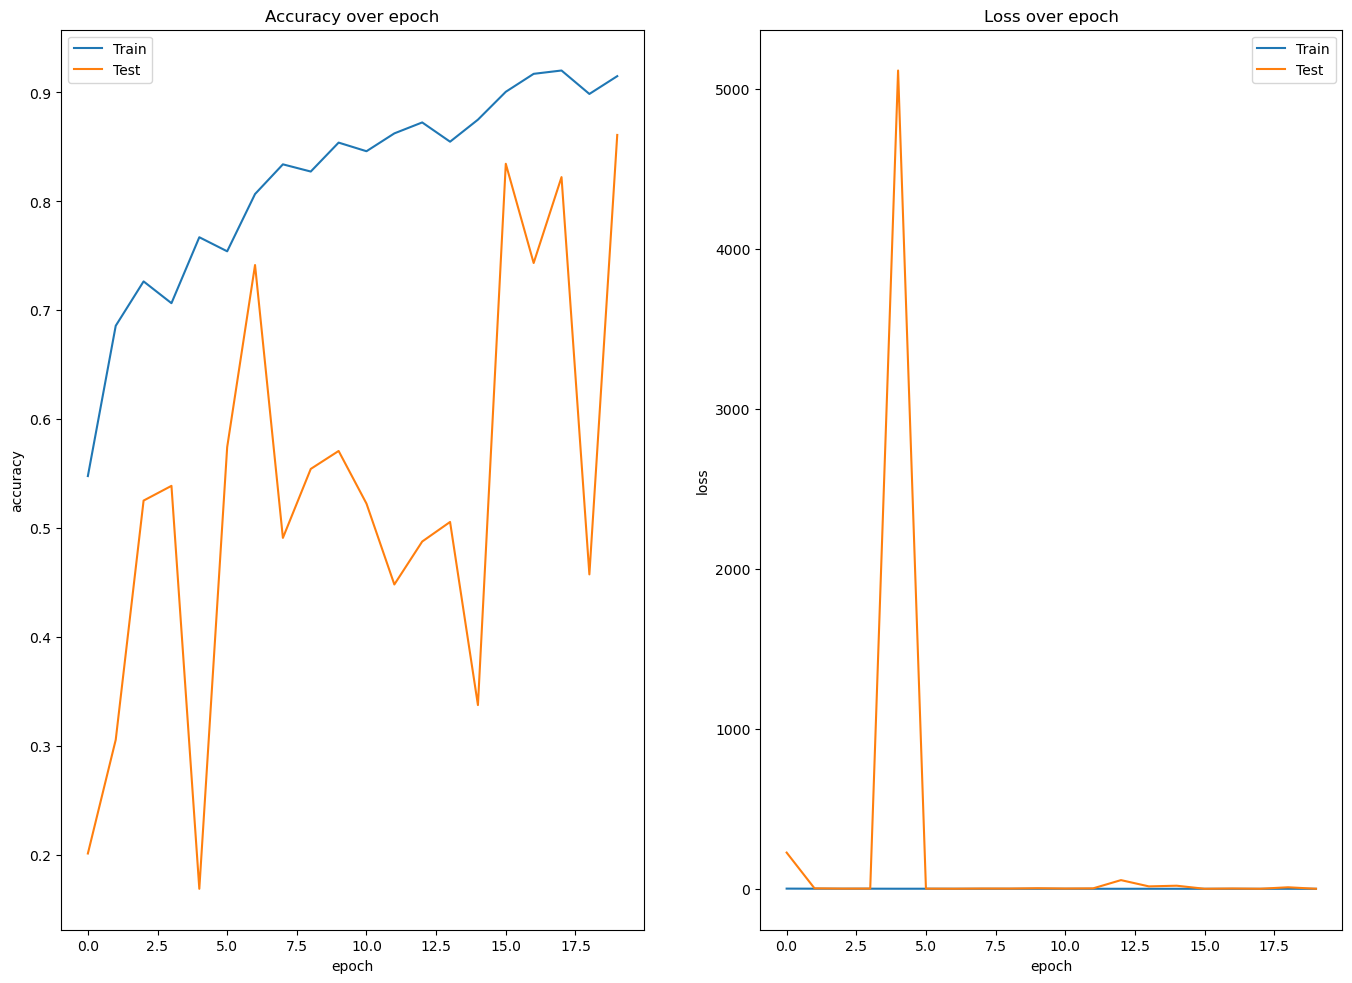

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

In [16]:
#confusion matrix

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━

In [17]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[ 875,   10,   35,    4,    3,   12,   86,    2,   43,    5],
       [   0, 1043,    3,    0,    0,    0,    0,    0,    0,   17],
       [   6,   81,  866,    6,    4,    0,   91,   12,    6,    8],
       [   4,    3,   43,  681,   18,    6,   61,   22,   36,    0],
       [   0,    0,   22,   12,  798,    0,    7,   36,    0,    0],
       [   7,  163,   40,    2,    0,  438,   31,    0,   35,    6],
       [   6,   23,  105,    0,    6,    3,  748,    0,   10,    0],
       [   0,   14,   12,    0,   12,    0,   16, 1012,    0,    0],
       [  20,   28,   25,   29,    3,    4,    6,    2,  763,    1],
       [  11,    8,    2,    0,    0,    6,    0,    0,    9, 1051]],
      dtype=int64)

In [18]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 875   10   35    4    3   12   86    2   43    5]
 [   0 1043    3    0    0    0    0    0    0   17]
 [   6   81  866    6    4    0   91   12    6    8]
 [   4    3   43  681   18    6   61   22   36    0]
 [   0    0   22   12  798    0    7   36    0    0]
 [   7  163   40    2    0  438   31    0   35    6]
 [   6   23  105    0    6    3  748    0   10    0]
 [   0   14   12    0   12    0   16 1012    0    0]
 [  20   28   25   29    3    4    6    2  763    1]
 [  11    8    2    0    0    6    0    0    9 1051]]


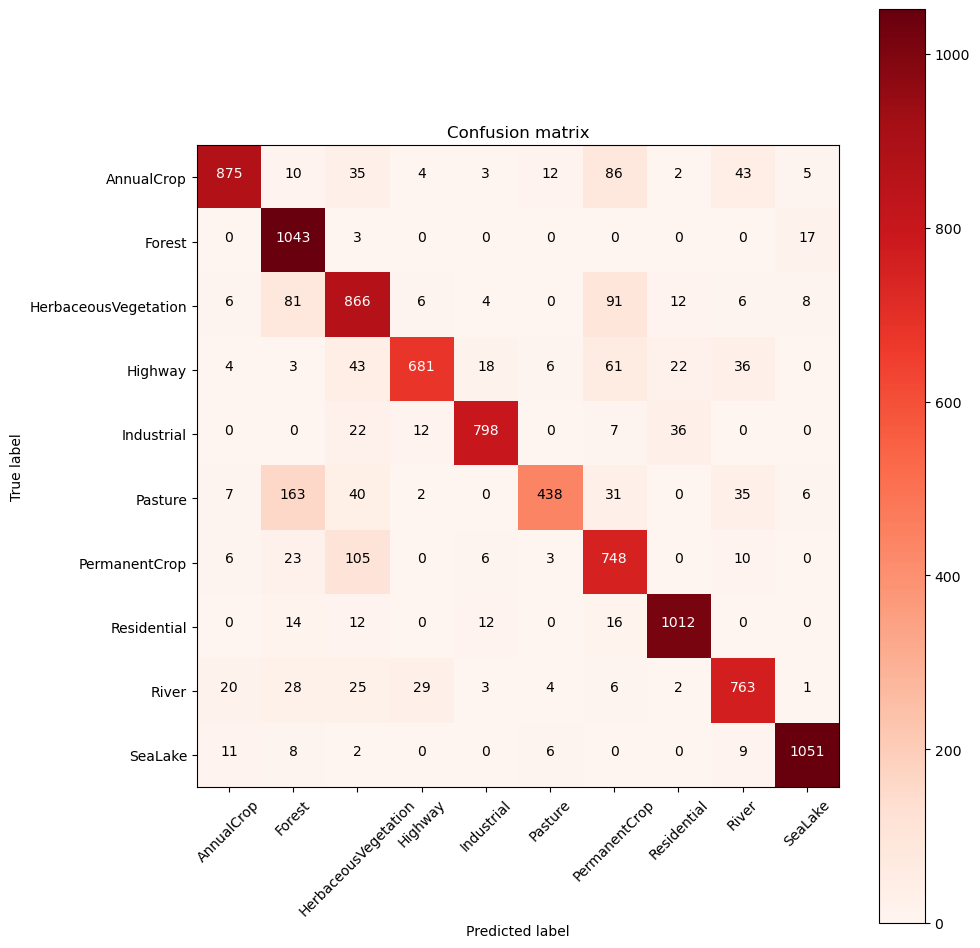

In [19]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')

In [20]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.8598 - loss: 0.4483
Test Loss: 0.44085389375686646
Test Accuracy: 0.8609259128570557


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix and classification report
y_pred = []  # store predicted labels
y_true = []  # store true labels

# Limit the number of batches to process (e.g., 100 batches for faster evaluation)
num_batches_to_process = 100

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset.take(num_batches_to_process)):   # limit the number of batches
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis=1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis=0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis=0)

# Compute the confusion matrix
cm = confusion_matrix(correct_labels, predicted_labels)
print(cm)

# Plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', figsize=(10, 10), cmap=plt.cm.Blues):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix using the modified function
plot_confusion_matrix(cm, list(train_dataset.class_indices.keys()), cmap='Reds')

# Print classification report
print(classification_report(correct_labels, predicted_labels, target_names=list(train_dataset.class_indices.keys())))


In [1]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Correct the file path
img_path = r"C:\S7-PROJECT\2750\River\River_24.jpg" # Use raw string notation

# Load an image from the directory and preprocess it
img = image.load_img(img_path, target_size=(64, 64))  # Ensure this matches your model input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

# Perform prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Get class indices from the training dataset
class_indices = train_dataset.class_indices

# Create a mapping from indices to class names
index_to_class = {v: k for k, v in class_indices.items()}

# Get the predicted class name
predicted_class_name = index_to_class[predicted_class_index]

print("Predicted class:", predicted_class_name)


NameError: name 'model' is not defined